In [1]:
from pyspark.sql.session import SparkSession


spark = SparkSession.builder.getOrCreate() 

24/04/02 18:13:18 WARN Utils: Your hostname, Macbooks-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.5.50.135 instead (on interface en0)
24/04/02 18:13:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/02 18:13:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark

In [3]:
# data = spark.read.csv("./sample_data - one_year.csv", header=True)
data = spark.read.csv("./sample_data - one_year.csv", header=True, inferSchema=True)

In [4]:
# if we prepare working with sql
data.createTempView("vw_dataset")

# Understand dataset

In [5]:
data.printSchema()

root
 |-- loan_amnt: integer (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: boolean (nullable = true)
 |-- monthly_income: double (nullable = true)
 |-- emp_industry: string (nullable = true)
 |-- age: integer (nullable = true)



## Get a few row

### By dataframe python api

In [6]:
data.show(2)

+---------+----------+--------+-----------+-----+---------+--------------------+----------+----------+-------+-----------+------------------+------------+---+
|loan_amnt|      term|int_rate|installment|grade|sub_grade|           emp_title|emp_length|annual_inc|issue_d|loan_status|    monthly_income|emp_industry|age|
+---------+----------+--------+-----------+-----+---------+--------------------+----------+----------+-------+-----------+------------------+------------+---+
|     5000| 36 months|   13.56|     169.83|    C|       C1|Public Affairs Sp...| 10+ years|  175000.0| Aug-18|      false|14583.333333333334|       other| 33|
|     4000| 36 months|    10.9|     130.77|    B|       B4|     Reception/Sales|    1 year|   25000.0| Mar-18|       true|2083.3333333333335|       other| 21|
+---------+----------+--------+-----------+-----+---------+--------------------+----------+----------+-------+-----------+------------------+------------+---+
only showing top 2 rows



### By Spark SQL

In [7]:
spark.sql("select * from vw_dataset limit 2").show();

+---------+----------+--------+-----------+-----+---------+--------------------+----------+----------+-------+-----------+------------------+------------+---+
|loan_amnt|      term|int_rate|installment|grade|sub_grade|           emp_title|emp_length|annual_inc|issue_d|loan_status|    monthly_income|emp_industry|age|
+---------+----------+--------+-----------+-----+---------+--------------------+----------+----------+-------+-----------+------------------+------------+---+
|     5000| 36 months|   13.56|     169.83|    C|       C1|Public Affairs Sp...| 10+ years|  175000.0| Aug-18|      false|14583.333333333334|       other| 33|
|     4000| 36 months|    10.9|     130.77|    B|       B4|     Reception/Sales|    1 year|   25000.0| Mar-18|       true|2083.3333333333335|       other| 21|
+---------+----------+--------+-----------+-----+---------+--------------------+----------+----------+-------+-----------+------------------+------------+---+



## Get a few columns

### By dataframe python api

In [8]:
data.select("loan_amnt", "term").show(10)

+---------+----------+
|loan_amnt|      term|
+---------+----------+
|     5000| 36 months|
|     4000| 36 months|
|     5000| 36 months|
|     5500| 36 months|
|    11200| 60 months|
|    36000| 60 months|
|    21925| 36 months|
|    10000| 36 months|
|     7925| 36 months|
|    10000| 36 months|
+---------+----------+
only showing top 10 rows



### By Spark SQL

In [9]:
df = spark.sql("select loan_amnt, term from vw_dataset")

In [10]:
df.select("*").show(2)

+---------+----------+
|loan_amnt|      term|
+---------+----------+
|     5000| 36 months|
|     4000| 36 months|
+---------+----------+
only showing top 2 rows



# Analyse data

## Loan group

In [11]:
from pyspark.sql.functions import when
new_df = data.withColumn("loan_group", when(data.loan_amnt > 5000, "big amount").otherwise("small amount"))

In [12]:
new_df.select("loan_group", "loan_amnt").groupby('loan_group').count().show()

+------------+-----+
|  loan_group|count|
+------------+-----+
|small amount| 6513|
|  big amount|43011|
+------------+-----+



<Axes: ylabel='Frequency'>

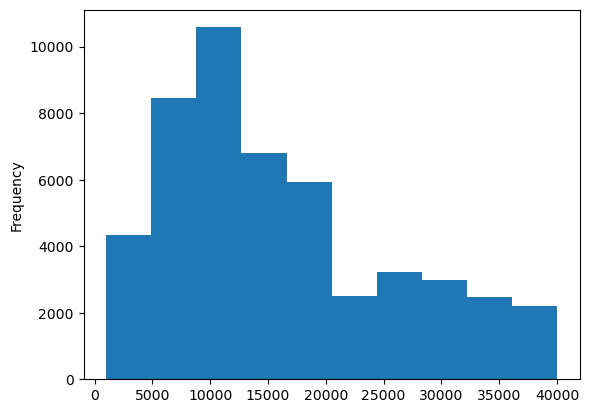

In [13]:
new_df.toPandas()['loan_amnt'].plot.hist()

## What is the average amount of Rejected Loan and approved loan?

In [14]:
data.select("loan_status", "loan_amnt").groupBy("loan_status").mean().show()

+-----------+------------------+
|loan_status|    avg(loan_amnt)|
+-----------+------------------+
|       true| 17016.26348665531|
|      false|15963.130848007073|
+-----------+------------------+



<Axes: xlabel='loan_amnt', ylabel='Count'>

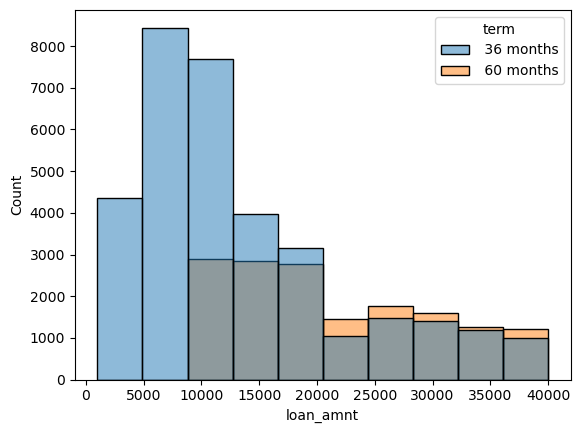

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

pandas_df = data.toPandas()

sns.histplot(pandas_df, x= pandas_df['loan_amnt'], hue='term', bins=10)

## Which employment title that likely to be rejected for the loan?

In [16]:
whole_count = data.groupby( "emp_title").count().sort(["count"], ascending=False)
whole_count.show(2)

+---------+-----+
|emp_title|count|
+---------+-----+
|    other| 5709|
|  Manager|  883|
+---------+-----+
only showing top 2 rows



In [17]:
reject_count = data.filter(data.loan_status == False).groupby( "emp_title").count().sort(["count"], ascending=False)
reject_count.show(3)

+---------+-----+
|emp_title|count|
+---------+-----+
|    other| 4486|
|  Manager|  715|
|  Teacher|  711|
+---------+-----+
only showing top 3 rows



In [18]:
w_count = whole_count.selectExpr("emp_title as w_emp_title", "count as w_count") 

df = w_count \
 .join(reject_count, w_count.w_emp_title == reject_count.emp_title)
df.show(3)

+--------------------+-------+--------------------+-----+
|         w_emp_title|w_count|           emp_title|count|
+--------------------+-------+--------------------+-----+
|Training Specialist |      3|Training Specialist |    3|
|           Physician|     35|           Physician|   32|
|           machinist|     16|           machinist|   14|
+--------------------+-------+--------------------+-----+
only showing top 3 rows



In [19]:
from pyspark.sql.functions import col

(df
 .withColumn("rejected_percentage", df["count"] / df.w_count )
 .filter(df.w_count >100)
 .sort("rejected_percentage", ascending=False)
 .show(10)
)

+--------------------+-------+--------------------+-----+-------------------+
|         w_emp_title|w_count|           emp_title|count|rejected_percentage|
+--------------------+-------+--------------------+-----+-------------------+
|            Director|    159|            Director|  141| 0.8867924528301887|
|      Office Manager|    242|      Office Manager|  214| 0.8842975206611571|
|               Nurse|    138|               Nurse|  120| 0.8695652173913043|
|    Registered Nurse|    364|    Registered Nurse|  316| 0.8681318681318682|
|     General Manager|    194|     General Manager|  168|  0.865979381443299|
|     Project Manager|    212|     Project Manager|  183| 0.8632075471698113|
|       Sales Manager|    123|       Sales Manager|  106| 0.8617886178861789|
|             Teacher|    828|             Teacher|  711| 0.8586956521739131|
|Administrative As...|    105|Administrative As...|   90| 0.8571428571428571|
|                  RN|    288|                  RN|  244| 0.8472

In [20]:
from pyspark.sql.functions import col

w_count = whole_count.selectExpr("emp_title as w_emp_title", "count as w_count") 
reject_probability = (w_count
 .join(reject_count, w_count.w_emp_title == reject_count.emp_title)
 .withColumn("rejected_percentage", col("count")/ col("w_count"))
 .filter(col("w_count") >10)
 .sort("rejected_percentage", ascending=False)
)
reject_probability.show(10)

+--------------------+-------+--------------------+-----+-------------------+
|         w_emp_title|w_count|           emp_title|count|rejected_percentage|
+--------------------+-------+--------------------+-----+-------------------+
|Special Education...|     15|Special Education...|   15|                1.0|
|          Bartender |     17|          Bartender |   17|                1.0|
|  Assistant Director|     12|  Assistant Director|   12|                1.0|
|            Sergeant|     12|            Sergeant|   12|                1.0|
|           Marketing|     12|           Marketing|   12|                1.0|
|Speech Language P...|     11|Speech Language P...|   11|                1.0|
|    Office Assistant|     12|    Office Assistant|   12|                1.0|
|Human Resources M...|     16|Human Resources M...|   16|                1.0|
|     Police officer |     14|     Police officer |   14|                1.0|
| Associate Professor|     17| Associate Professor|   17|       

In [21]:
reject_probability.printSchema()

root
 |-- w_emp_title: string (nullable = true)
 |-- w_count: long (nullable = false)
 |-- emp_title: string (nullable = true)
 |-- count: long (nullable = false)
 |-- rejected_percentage: double (nullable = true)



<Axes: xlabel='rejected_percentage', ylabel='Count'>

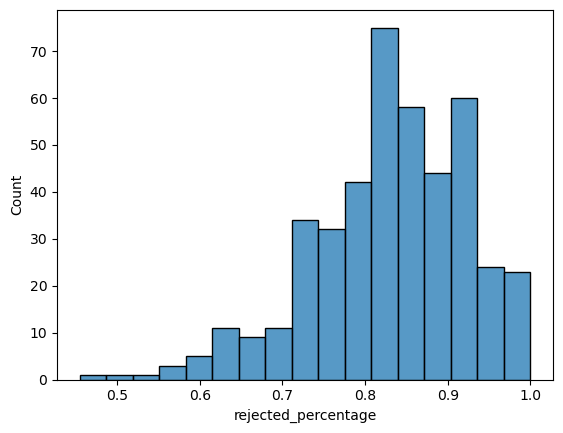

In [22]:
pd_reject = reject_probability.toPandas()
sns.histplot(pd_reject, x=pd_reject['rejected_percentage'], stat="count")

## Does the loan status impacted by employment title or not?

In [23]:
# Base in asumption, employment title does not impact much to loan status

## Which grades that likely to be approve for the loan?

In [24]:
approve_loan = data.filter(data["loan_status"] == True).select("grade").groupby("grade").count()
approve_loan.show()

+-----+-----+
|grade|count|
+-----+-----+
|    F|  237|
|    E|  876|
|    B| 1768|
|    D| 2482|
|    C| 2730|
|    A|  656|
|    G|   56|
+-----+-----+



In [25]:
data.select("grade").groupby("grade").count().show(2)

+-----+-----+
|grade|count|
+-----+-----+
|    F|  502|
|    E| 2409|
+-----+-----+
only showing top 2 rows



In [26]:
all_loan_by_grade = data.select("grade").groupby("grade").count().selectExpr("grade as all_loan_grade", "count as all_loan_count")
all_loan_by_grade.show()

+--------------+--------------+
|all_loan_grade|all_loan_count|
+--------------+--------------+
|             F|           502|
|             E|          2409|
|             B|         13481|
|             D|          8154|
|             C|         13103|
|             A|         11781|
|             G|            94|
+--------------+--------------+



In [27]:
# joint_dataset = all_loan_by_grade.join(approve_loan, all_loan_by_grade.all_loan_grade == approve_loan.grade) 

joint_dataset = all_loan_by_grade.join(approve_loan, all_loan_by_grade["all_loan_grade"] == approve_loan["grade"])
joint_dataset.show()

+--------------+--------------+-----+-----+
|all_loan_grade|all_loan_count|grade|count|
+--------------+--------------+-----+-----+
|             F|           502|    F|  237|
|             E|          2409|    E|  876|
|             B|         13481|    B| 1768|
|             D|          8154|    D| 2482|
|             C|         13103|    C| 2730|
|             A|         11781|    A|  656|
|             G|            94|    G|   56|
+--------------+--------------+-----+-----+



In [28]:
joint_dataset.withColumn("percentage", joint_dataset["count"] / joint_dataset["all_loan_count"]).sort("percentage", ascending=False).show()

+--------------+--------------+-----+-----+--------------------+
|all_loan_grade|all_loan_count|grade|count|          percentage|
+--------------+--------------+-----+-----+--------------------+
|             G|            94|    G|   56|  0.5957446808510638|
|             F|           502|    F|  237|  0.4721115537848606|
|             E|          2409|    E|  876| 0.36363636363636365|
|             D|          8154|    D| 2482|  0.3043904831984302|
|             C|         13103|    C| 2730| 0.20834923300007632|
|             B|         13481|    B| 1768| 0.13114754098360656|
|             A|         11781|    A|  656|0.055682879212290974|
+--------------+--------------+-----+-----+--------------------+



## What are applicant's grades within dataset?

In [29]:
data.select("grade").distinct().show()

+-----+
|grade|
+-----+
|    F|
|    E|
|    B|
|    D|
|    C|
|    A|
|    G|
+-----+



## What are minimun and maximum interest rate in the datasets?

In [37]:
from pyspark.sql.functions import min, max
data.select(min("int_rate"), max("int_rate")).show()

+-------------+-------------+
|min(int_rate)|max(int_rate)|
+-------------+-------------+
|         5.31|        30.99|
+-------------+-------------+



In [38]:
from pyspark.sql.functions import min, max
data.select(min("int_rate"), max("int_rate")).show()

+-------------+-------------+
|min(int_rate)|max(int_rate)|
+-------------+-------------+
|         5.31|        30.99|
+-------------+-------------+



In [39]:
data.createOrReplaceTempView("view_data")

In [40]:
spark.sql("select min(int_rate), max(int_rate), avg(int_rate), count(int_rate) from view_data").show()

+-------------+-------------+------------------+---------------+
|min(int_rate)|max(int_rate)|     avg(int_rate)|count(int_rate)|
+-------------+-------------+------------------+---------------+
|         5.31|        30.99|13.337527461432392|          49524|
+-------------+-------------+------------------+---------------+



## What are minimun and maximum interest rate in the rejected loan?

In [41]:
data.filter(data["loan_status"] == False).select(min("int_rate"), max("int_rate")).show()

+-------------+-------------+
|min(int_rate)|max(int_rate)|
+-------------+-------------+
|         5.31|        30.99|
+-------------+-------------+



In [42]:
spark.sql("select min(int_rate), max(int_rate) from view_data where loan_status = FALSE").show()

+-------------+-------------+
|min(int_rate)|max(int_rate)|
+-------------+-------------+
|         5.31|        30.99|
+-------------+-------------+



## What are minimun and maximum interest rate in the approved loan?

In [43]:
data.filter(data["loan_status"] == True).select(min("int_rate"), max("int_rate")).show()

+-------------+-------------+
|min(int_rate)|max(int_rate)|
+-------------+-------------+
|         5.31|        30.99|
+-------------+-------------+



In [44]:
spark.sql("select min(int_rate), max(int_rate) from view_data where loan_status = True").show()

+-------------+-------------+
|min(int_rate)|max(int_rate)|
+-------------+-------------+
|         5.31|        30.99|
+-------------+-------------+



# Does age affect loan status or not

<Axes: xlabel='age', ylabel='Count'>

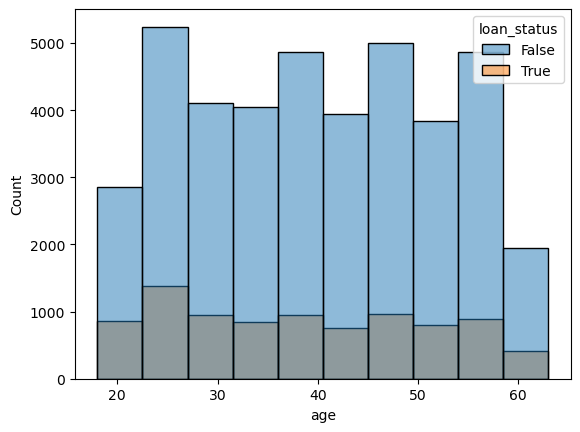

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

age_df = data.select("age", "loan_status").toPandas()
sns.histplot(age_df, x="age", hue="loan_status", bins=10)

# In each age group, how many applications in total, rejected applications, approved applications ?

In [68]:
# 20 to 30, total 10000, approved 100, rejected 900
# 30 to 40, total 20000, approved 100, rejected 1900
from pyspark.sql.functions import when

age_group_df = data.select("age", "loan_status")\
    .withColumn("age_group", \
                        when( data.age <20 , "1. <20s years old" )\
                        .when(data.age <30, "2. 20s years old") \
                        .when(data.age <40, "3. 30s years old") \
                        .when(data.age <50, "4. 40s years old") \
                        .when(data.age <60, "5. 50s years old") \
                        .otherwise("6. >=60 years old") \
)
age_group_df.show()

+---+-----------+----------------+
|age|loan_status|       age_group|
+---+-----------+----------------+
| 33|      false|3. 30s years old|
| 21|       true|2. 20s years old|
| 56|       true|5. 50s years old|
| 20|      false|2. 20s years old|
| 23|       true|2. 20s years old|
| 48|       true|4. 40s years old|
| 58|       true|5. 50s years old|
| 24|       true|2. 20s years old|
| 34|      false|3. 30s years old|
| 24|       true|2. 20s years old|
| 23|      false|2. 20s years old|
| 35|      false|3. 30s years old|
| 34|      false|3. 30s years old|
| 47|      false|4. 40s years old|
| 59|      false|5. 50s years old|
| 43|      false|4. 40s years old|
| 33|      false|3. 30s years old|
| 24|       true|2. 20s years old|
| 30|       true|3. 30s years old|
| 25|       true|2. 20s years old|
+---+-----------+----------------+
only showing top 20 rows



In [72]:
all_age = age_group_df.groupby("age_group").count()
all_age.show()

+-----------------+-----+
|        age_group|count|
+-----------------+-----+
| 3. 30s years old|11078|
| 4. 40s years old|11867|
| 2. 20s years old|12598|
| 5. 50s years old|11509|
|6. >=60 years old| 1247|
|1. <20s years old| 1225|
+-----------------+-----+



In [82]:
approved_age = age_group_df.filter(age_group_df.loan_status == True).groupby("age_group").count()
approved_age = approved_age.selectExpr("age_group as a_age_group", "count as a_count")
approved_age.show()

+-----------------+-------+
|      a_age_group|a_count|
+-----------------+-------+
| 3. 30s years old|   1893|
| 4. 40s years old|   1928|
| 2. 20s years old|   2591|
| 5. 50s years old|   1879|
|6. >=60 years old|    210|
|1. <20s years old|    304|
+-----------------+-------+



In [83]:
rejected_age = age_group_df.filter(age_group_df.loan_status == False).groupby("age_group").count()
rejected_age = rejected_age.selectExpr("age_group as r_age_group", "count as r_count")
rejected_age.show()

+-----------------+-------+
|      r_age_group|r_count|
+-----------------+-------+
| 3. 30s years old|   9185|
| 4. 40s years old|   9939|
| 2. 20s years old|  10007|
| 5. 50s years old|   9630|
|6. >=60 years old|   1037|
|1. <20s years old|    921|
+-----------------+-------+



In [84]:
all_join_approved = all_age.join(approved_age, all_age.age_group == approved_age.a_age_group)
all_join_approved.show()

+-----------------+-----+-----------------+-------+
|        age_group|count|      a_age_group|a_count|
+-----------------+-----+-----------------+-------+
| 3. 30s years old|11078| 3. 30s years old|   1893|
| 4. 40s years old|11867| 4. 40s years old|   1928|
| 2. 20s years old|12598| 2. 20s years old|   2591|
| 5. 50s years old|11509| 5. 50s years old|   1879|
|6. >=60 years old| 1247|6. >=60 years old|    210|
|1. <20s years old| 1225|1. <20s years old|    304|
+-----------------+-----+-----------------+-------+



In [163]:
result = all_join_approved.join(rejected_age, all_join_approved.age_group == rejected_age.r_age_group, "outer")
result.select("age_group", "count", "a_count", "r_count").show()

+-----------------+-----+-------+-------+
|        age_group|count|a_count|r_count|
+-----------------+-----+-------+-------+
|1. <20s years old| 1225|    304|    921|
| 2. 20s years old|12598|   2591|  10007|
| 3. 30s years old|11078|   1893|   9185|
| 4. 40s years old|11867|   1928|   9939|
| 5. 50s years old|11509|   1879|   9630|
|6. >=60 years old| 1247|    210|   1037|
+-----------------+-----+-------+-------+



In [115]:
age_group_df = data.select("age", "loan_status")\
    .withColumn("age_group", \
                        when( data.age <20 , "1. <20s years old" )\
                        .when(data.age <30, "2. 20s years old") \
                        .when(data.age <40, "3. 30s years old") \
                        .when(data.age <50, "4. 40s years old") \
                        .when(data.age <60, "5. 50s years old") \
                        .otherwise("6. >=60 years old")) \
    .withColumn("count",  when(data.loan_status.isNull(), 0).otherwise(1)) \
    .withColumn("approved",  when(data.loan_status == True, 1).otherwise(0)) \
    .withColumn("rejected",  when(data.loan_status == False, 1).otherwise(0)) 


age_group_df.show()

+---+-----------+----------------+-----+--------+--------+
|age|loan_status|       age_group|count|approved|rejected|
+---+-----------+----------------+-----+--------+--------+
| 33|      false|3. 30s years old|    1|       0|       1|
| 21|       true|2. 20s years old|    1|       1|       0|
| 56|       true|5. 50s years old|    1|       1|       0|
| 20|      false|2. 20s years old|    1|       0|       1|
| 23|       true|2. 20s years old|    1|       1|       0|
| 48|       true|4. 40s years old|    1|       1|       0|
| 58|       true|5. 50s years old|    1|       1|       0|
| 24|       true|2. 20s years old|    1|       1|       0|
| 34|      false|3. 30s years old|    1|       0|       1|
| 24|       true|2. 20s years old|    1|       1|       0|
| 23|      false|2. 20s years old|    1|       0|       1|
| 35|      false|3. 30s years old|    1|       0|       1|
| 34|      false|3. 30s years old|    1|       0|       1|
| 47|      false|4. 40s years old|    1|       0|       

In [117]:
age_group_df.drop("age").groupby("age_group").sum().sort("age_group").show()

+-----------------+----------+-------------+-------------+
|        age_group|sum(count)|sum(approved)|sum(rejected)|
+-----------------+----------+-------------+-------------+
|1. <20s years old|      1225|          304|          921|
| 2. 20s years old|     12598|         2591|        10007|
| 3. 30s years old|     11078|         1893|         9185|
| 4. 40s years old|     11867|         1928|         9939|
| 5. 50s years old|     11509|         1879|         9630|
|6. >=60 years old|      1247|          210|         1037|
+-----------------+----------+-------------+-------------+



In [161]:
from pyspark.sql.functions import col
from pyspark.sql.types import DecimalType

re = age_group_df \
    .drop("age") \
    .groupby("age_group") \
    .sum() \
    .sort("age_group") \
    .withColumn("approved_percentage", col("sum(approved)") / col("sum(count)")) \
    .withColumn("rejected_percentage", col("sum(rejected)") / col("sum(count)")) \

re.show()

+-----------------+----------+-------------+-------------+-------------------+-------------------+
|        age_group|sum(count)|sum(approved)|sum(rejected)|approved_percentage|rejected_percentage|
+-----------------+----------+-------------+-------------+-------------------+-------------------+
|1. <20s years old|      1225|          304|          921|0.24816326530612245| 0.7518367346938776|
| 2. 20s years old|     12598|         2591|        10007|0.20566756628036195|  0.794332433719638|
| 3. 30s years old|     11078|         1893|         9185|0.17087922007582595|  0.829120779924174|
| 4. 40s years old|     11867|         1928|         9939| 0.1624673464228533| 0.8375326535771467|
| 5. 50s years old|     11509|         1879|         9630|0.16326353288730558| 0.8367364671126944|
|6. >=60 years old|      1247|          210|         1037|0.16840417000801924| 0.8315958299919808|
+-----------------+----------+-------------+-------------+-------------------+-------------------+



In [162]:
from pyspark.sql.functions import round, floor, ceil

re \
    .withColumn("approved_percentage", round(re.approved_percentage, 2)) \
    .withColumn("rejected_percentage", re.rejected_percentage.cast(DecimalType(18, 2))) \
.show()

+-----------------+----------+-------------+-------------+-------------------+-------------------+
|        age_group|sum(count)|sum(approved)|sum(rejected)|approved_percentage|rejected_percentage|
+-----------------+----------+-------------+-------------+-------------------+-------------------+
|1. <20s years old|      1225|          304|          921|               0.25|               0.75|
| 2. 20s years old|     12598|         2591|        10007|               0.21|               0.79|
| 3. 30s years old|     11078|         1893|         9185|               0.17|               0.83|
| 4. 40s years old|     11867|         1928|         9939|               0.16|               0.84|
| 5. 50s years old|     11509|         1879|         9630|               0.16|               0.84|
|6. >=60 years old|      1247|          210|         1037|               0.17|               0.83|
+-----------------+----------+-------------+-------------+-------------------+-------------------+



# Is interest rate lower if my income higher?

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns

int_and_income = data.select("loan_status","int_rate", "monthly_income").toPandas()
int_and_income.head()

,loan_status,int_rate,monthly_income
0,False,13.56,14583.333333
1,True,10.90,2083.333333
2,True,23.40,10000.000000
3,False,14.47,2191.666667
4,True,16.14,2916.666667


<Axes: ylabel='Frequency'>

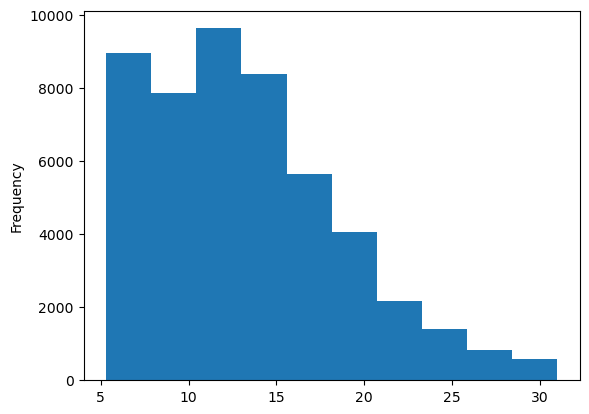

In [201]:
int_and_income["int_rate"].plot.hist()

<Axes: xlabel='monthly_income', ylabel='Count'>

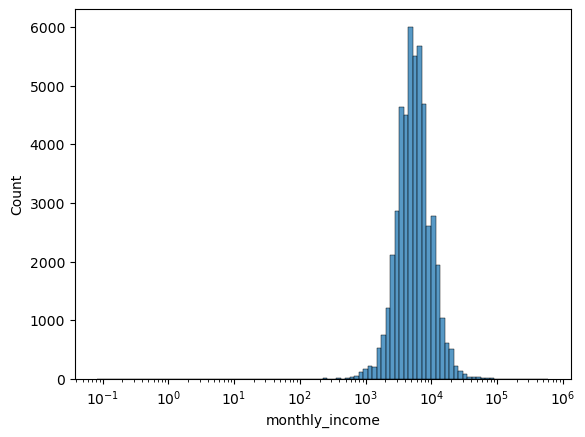

In [202]:
import numpy as np

sns.histplot(int_and_income[int_and_income["monthly_income"]>0]["monthly_income"], bins=100, log_scale=True)

<Axes: xlabel='monthly_income', ylabel='int_rate'>

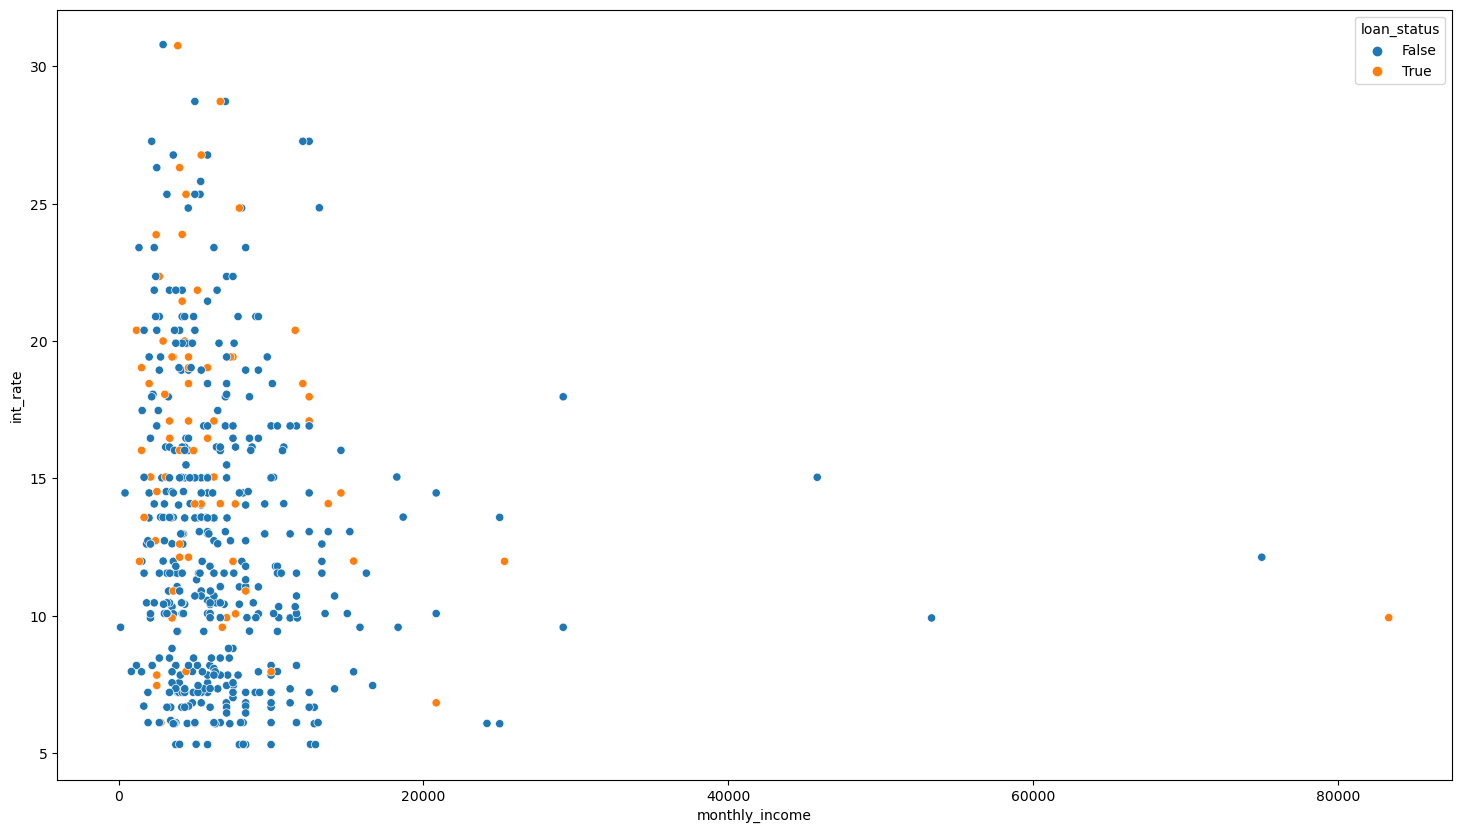

In [205]:
fig, axes = plt.subplots(figsize=(18, 10))

sns.scatterplot(int_and_income[int_and_income["monthly_income"]<100_000].sample(500), x="monthly_income", y="int_rate", hue="loan_status")

<Axes: xlabel='grade', ylabel='int_rate'>

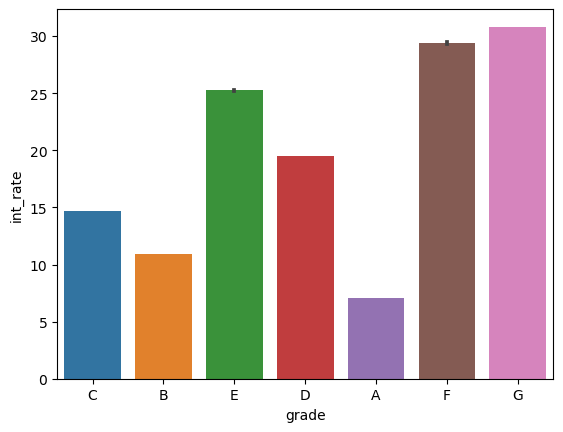

In [215]:
sns.barplot(data.toPandas(), x="grade", y="int_rate", estimator="mean" )

 # If prefer to work with pandas

In [ ]:
data.to_pandas_on_spark()